In [1]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import elasticsearch
import os
pd.options.plotting.backend = "plotly"

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
avg_over_min = 1
days_look_back = 20

In [3]:
en_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
st_date = (datetime.now() - timedelta(days=days_look_back)).strftime('%Y-%m-%dT%H:%M:%S')

en_date_dt = datetime.now().astimezone(pytz.timezone('America/New_York'))
st_date_dt = (datetime.now() - timedelta(days=days_look_back)).astimezone(pytz.timezone('America/New_York'))

st_date_utc = datetime.strptime(st_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
en_date_utc = datetime.strptime(en_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')

In [4]:
print(st_date_utc)
print(en_date_utc)

2022-03-25T20:09:08Z
2022-04-14T20:09:08Z


In [5]:
# Import and format Praxis data
uri = 'https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&' \
'startTime=%s&endTime=%s&checkpoint=**:/%i:00' \
% (st_date_utc, en_date_utc, avg_over_min)
print(uri)
praxis_df = pd.DataFrame([])

while uri != '':
    header = {"authorization": "api-key nyu-brooklyn"}
    response = requests.get(uri, headers=header)
    json = response.json()

    data = {}

    data['ts'] = pd.to_datetime([ele['rec'] for ele in json['Items']]).tz_convert(tz='US/Eastern')

    data['praxis_pm1_vals'] = [ele['val']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals'] = [ele['val']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals'] = [ele['val']['pm10'] for ele in json['Items']]

    data['praxis_pm1_vals_adj'] = [ele['exg']['rn20']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals_adj'] = [ele['exg']['rn20']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals_adj'] = [ele['exg']['rn20']['pm10'] for ele in json['Items']]

#     praxis_df = pd.DataFrame(data).set_index('ts').resample(avg_over).mean()

    if 'next' in json:
        uri = json['next']
    else:
        uri = ''
    praxis_df = pd.concat([praxis_df, pd.DataFrame(data)])
    
    time.sleep(0.5)
praxis_df = praxis_df.set_index('ts').resample('%iT' % avg_over_min).mean()
praxis_df = praxis_df.loc[st_date_dt:en_date_dt]

https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&startTime=2022-03-25T20:09:08Z&endTime=2022-04-14T20:09:08Z&checkpoint=**:/1:00


In [6]:
praxis_df

,praxis_pm1_vals,praxis_pm2p5_vals,praxis_pm10_vals,praxis_pm1_vals_adj,praxis_pm2p5_vals_adj,praxis_pm10_vals_adj
ts,,,,,,
2022-03-25 16:10:00-04:00,0.6,1.0,3.2,3.8,5.0,8.6
2022-03-25 16:11:00-04:00,0.6,1.3,2.0,3.3,4.8,9.7
2022-03-25 16:12:00-04:00,0.6,1.2,2.9,3.8,5.1,9.9
2022-03-25 16:13:00-04:00,0.7,1.4,3.4,3.7,5.1,11.6
2022-03-25 16:14:00-04:00,0.5,1.1,4.2,3.2,4.7,8.7
...,...,...,...,...,...,...
2022-04-14 16:05:00-04:00,2.2,6.1,14.6,6.9,9.8,24.5
2022-04-14 16:06:00-04:00,2.5,7.6,14.4,7.8,10.9,24.2
2022-04-14 16:07:00-04:00,2.5,8.4,19.2,7.9,10.2,22.3


In [7]:
st_time ="2022-03-29 10:55:00-04:00"
praxis_df2 = praxis_df.loc['2022-03-19 14:48:00-04:00':'2022-03-29 10:55:00-04:00']
praxis_df2

,praxis_pm1_vals,praxis_pm2p5_vals,praxis_pm10_vals,praxis_pm1_vals_adj,praxis_pm2p5_vals_adj,praxis_pm10_vals_adj
ts,,,,,,
2022-03-25 16:10:00-04:00,0.6,1.0,3.2,3.8,5.0,8.6
2022-03-25 16:11:00-04:00,0.6,1.3,2.0,3.3,4.8,9.7
2022-03-25 16:12:00-04:00,0.6,1.2,2.9,3.8,5.1,9.9
2022-03-25 16:13:00-04:00,0.7,1.4,3.4,3.7,5.1,11.6
2022-03-25 16:14:00-04:00,0.5,1.1,4.2,3.2,4.7,8.7
...,...,...,...,...,...,...
2022-03-29 10:51:00-04:00,4.6,5.8,8.3,14.3,15.8,21.6
2022-03-29 10:52:00-04:00,6.0,7.4,12.9,28.6,29.1,46.6
2022-03-29 10:53:00-04:00,0.9,1.8,14.0,3.4,5.2,30.1


In [8]:
# Import and format Piera Canary data
# 168
canary_df = pd.DataFrame([])

for x in range(840):
    uri = 'https://sensei.pierasystems.com/api/get-minute-averages/318?page=%i' % x
    response = requests.get(uri)
    json = response.json()
    data = {}
    if json["data"] == "":
        break
    data['ts'] = pd.to_datetime([ele['time'] for ele in json['data']]).tz_convert(tz='US/Eastern')
    
    data['canary_pm1_vals'] = [ele['pm10'] for ele in json['data']]
    data['canary_pm2p5_vals'] = [ele['pm25'] for ele in json['data']]
    data['canary_pm10_vals'] = [ele['pm100'] for ele in json['data']]
    data['canary_temp'] = [ele['temp'] for ele in json['data']]
    data['canary_rh'] = [ele['rh'] for ele in json['data']]
    
    canary_df = pd.concat([canary_df, pd.DataFrame(data)])

    if canary_df['ts'].iloc[-1] < pd.DatetimeIndex([st_date_dt]):
        break
    time.sleep(0.5)
    
canary_df = canary_df.set_index('ts').resample('%iT' % avg_over_min).mean()
canary_df = canary_df.loc[st_date_dt:en_date_dt]

In [9]:
print(st_date_dt)

2022-03-25 16:09:08.374753-04:00


In [10]:
canary_df


,canary_pm1_vals,canary_pm2p5_vals,canary_pm10_vals,canary_temp,canary_rh
ts,,,,,
2022-03-25 16:10:00-04:00,0.388139,0.858299,0.962699,15.1,40.6
2022-03-25 16:11:00-04:00,0.285649,0.337889,0.337889,14.8,41.2
2022-03-25 16:12:00-04:00,0.324926,0.455526,0.455526,14.8,41.4
2022-03-25 16:13:00-04:00,0.301340,0.588660,0.588660,14.7,41.5
2022-03-25 16:14:00-04:00,0.235787,0.379447,0.379447,14.6,41.9
...,...,...,...,...,...
2022-03-29 10:51:00-04:00,44.171700,61.567600,62.194000,3.9,31.2
2022-03-29 10:52:00-04:00,48.791900,76.113500,76.322300,4.0,30.9
2022-03-29 10:53:00-04:00,8.878470,9.400870,9.400870,3.9,30.8


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


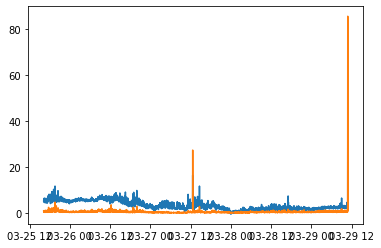

In [11]:

import matplotlib.pyplot as plt
%matplotlib inline

P =plt.plot(praxis_df2.index,praxis_df2["praxis_pm2p5_vals_adj"]) ##BLUE
P =plt.plot(canary_df.index,canary_df["canary_pm2p5_vals"])

In [12]:
uri = 'https://api.thingspeak.com/channels/1530870/feeds.json?api_key=U4IJYTKQ1ON601M3&average=%i&days=%i' \
% (avg_over_min, days_look_back)
print(uri)
response = requests.get(uri)
json = response.json()
data = {}
data['ts'] = pd.to_datetime([ele['created_at'] for ele in json['feeds']]).tz_convert(tz='US/Eastern')
    
data['purple_pm1_vals'] = [ele['field1'] for ele in json['feeds']]
data['purple_pm2p5_vals'] = [ele['field2'] for ele in json['feeds']]
data['purple_pm10_vals'] = [ele['field3'] for ele in json['feeds']]

purple_df = pd.DataFrame(data)
    
# purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean().interpolate(method='pad', limit=2)
purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean()
purple_df = purple_df.loc[st_date_dt:en_date_dt]

https://api.thingspeak.com/channels/1530870/feeds.json?api_key=U4IJYTKQ1ON601M3&average=1&days=20


In [13]:
purple_df

,purple_pm1_vals,purple_pm2p5_vals,purple_pm10_vals
ts,,,
2022-04-03 11:41:00-04:00,4.27,8.31,9.00
2022-04-03 11:42:00-04:00,NaN,NaN,NaN
2022-04-03 11:43:00-04:00,4.51,7.40,7.74
2022-04-03 11:44:00-04:00,NaN,NaN,NaN
2022-04-03 11:45:00-04:00,4.13,7.93,8.20
...,...,...,...
2022-04-14 16:05:00-04:00,7.02,11.06,11.83
2022-04-14 16:06:00-04:00,NaN,NaN,NaN
2022-04-14 16:07:00-04:00,7.12,11.96,13.52


In [14]:
comb_df = canary_df.join(praxis_df)
comb_df = comb_df.join(purple_df)

In [15]:
GROUP = time.time()

def scroll(es, index, body, scroll='2m', size=1000, timeout=25, **kw):
    if isinstance(timeout, int):
        timeout = '{}s'.format(int(timeout))
    page = es.search(index=index, body=body, scroll=scroll, size=size, timeout=timeout, **kw)
    scroll_id, hits = page['_scroll_id'], page['hits']['hits']
    while len(hits):
        yield hits
        page = es.scroll(scroll_id=scroll_id, scroll=scroll)
        scroll_id, hits = page['_scroll_id'], page['hits']['hits']
        
def sensor_query(key=None, nodeid=None, start=None, end=None, k_time="time", group=GROUP):
    match = []
    if key and nodeid:
        match.append({"term": {f'{key}.keyword': nodeid}})
    end = end or 'now'
    if start:
        match.append({"range" : {k_time : {"gte" : start, "lte" : end}}})
    elif end:
        match.append({"range" : {k_time : {"lte" : end}}})
    return { "query": { "bool": {"must": match} } } if match else {}

def download_sensor_data(table, key=None, nodeid=None, start=None, end=None, save=True, k_time='time', **kw):
    query = sensor_query(key, nodeid, start, end, k_time=k_time, **kw)
    print(query)
    
    def pull():
        with tqdm(scroll(es, table, query)) as pbar:
            for i, hits in enumerate(pbar):
                hits = [h['_source'] for h in hits]
                times = [h[k_time] for h in hits]
                pbar.write('{}. n hits: {}. {} - {}'.format(i, len(hits), min(times), max(times)))
                for h in hits:
                    yield h
    if not save:
        return list(pull())

    fname = 'data/{}/{}.json'.format(group, nodeid or table)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    print(f'Pulling node={nodeid} for ({start} -> {end}) ... saving to {fname}')
    with open(fname, 'w') as f:
        for h in pull():
            f.write(json.dumps(h) + '\n')
    print('all done!')
    return fname

In [16]:
# ss[0]['aq']

In [17]:
# fig = comb_df[['canary_pm2p5_vals', 'praxis_pm2p5_vals_adj', 'praxis_pm2p5_vals', 'purple_pm2p5_vals', 'piera7100_pm2p5_vals']].plot();
fig = comb_df[['canary_pm2p5_vals', 'praxis_pm2p5_vals_adj', 'praxis_pm2p5_vals', 'purple_pm2p5_vals']].plot();
fig.show()

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
df_main = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"], 'Temp': canary_df["canary_temp"], 'RelHum': canary_df["canary_rh"]})

X = df_main[['Sensor_O1','Temp', 'RelHum']]
Y = df_main['RefSt']
X= X.fillna(X.mean())
Y=Y.fillna(Y.mean())



In [42]:
X_MLRtrain, X_MLRtest, Y_MLRtrain, Y_MLRtest = train_test_split(X, Y, test_size = 0.1, random_state = 1, shuffle = False)

# ee = OneClassSVM(nu=0.51)
# yhat = ee.fit_predict(X_MLRtrain)
# # select all rows that are not outliers
# mask = yhat != -1
# X_MLRtrain, Y_MLRtrain = X_MLRtrain[mask], Y_MLRtrain[mask]


df_MLRtrain = pd.DataFrame({'RefSt': Y_MLRtrain, 'Sensor_O1': X_MLRtrain["Sensor_O1"],'Temp': X_MLRtrain["Temp"], 'RelHum': X_MLRtrain["RelHum"]})
df_MLRtest = pd.DataFrame({'RefSt': Y_MLRtest, 'Sensor_O1': X_MLRtest["Sensor_O1"],'Temp': X_MLRtest["Temp"], 'RelHum': X_MLRtest["RelHum"]})



In [43]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def loss_functions(y_true, y_pred):
    print("Loss functions:")
    print("* R-squared =", r2_score(y_true, y_pred))
    print("* RMSE =", mean_squared_error(y_true, y_pred))
    print("* MAE =", mean_absolute_error(y_true, y_pred))


# %%
# Normalise sensor data
def normalize(col):
    μ = col.mean()
    sig = col.std()
    return (col - μ)/sig

df_main["normRefSt"] = normalize(df_main["RefSt"])
df_main["normSensor_O3"] = normalize(df_main["Sensor_O1"])
df_main["normTemp"] = normalize(df_main["Temp"])
df_main["normRelHum"] = normalize(df_main["RelHum"])


In [44]:
Sensor_O3_RefSt_factor = df_main[["Sensor_O1", "RefSt"]]
#Sensor_O3_RefSt_factor["RefSt"] = Sensor_O3_RefSt_factor["RefSt"]
Sensor_O3_RefSt_factor.plot()

In [45]:
# X_train, Y_train;

Intercept: 
 1.300769305732738
Coefficients: 
 [0.81543244 0.25444219 0.00644899]
0.7616777087120283
Loss functions:
* R-squared = -3.3774943527953756
* RMSE = 15.373258197628736
* MAE = 1.2019516593651558


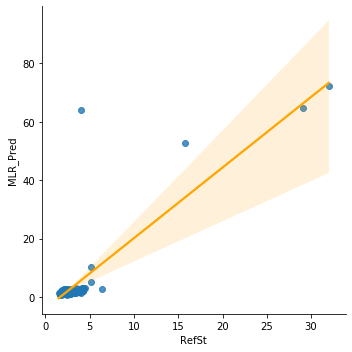

In [46]:
from sklearn.linear_model import LinearRegression

import seaborn as sns
# Model
lr = LinearRegression()


# Fit
lr.fit(X_MLRtrain, Y_MLRtrain)

# Get MLR coefficients
print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)

# Predict
df_MLRtest["MLR_Pred"] = lr.intercept_ + lr.coef_[0]*df_MLRtest["Sensor_O1"] + lr.coef_[1]*df_MLRtest["Temp"] + lr.coef_[2]*df_MLRtest["RelHum"]

# Plot linear
df_MLRtest[["RefSt", "MLR_Pred"]].plot()
print(lr.score(X_MLRtrain, Y_MLRtrain))


# Plot regression
sns.lmplot(x = 'RefSt', y = 'MLR_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["MLR_Pred"])

In [47]:
# plt.plot(praxis_df2.index,praxis_df2["praxis_pm2p5_vals_adj"]) ##BLUE
# plt.plot(df_test["MLR_Pred"] )
# canary_df.index,canary_df["canary_pm2p5_vals"]##BLUE

df2_check = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': df_MLRtest["MLR_Pred"]})
Sensor_O3_RefSt = df2_check[["Sensor_O1", "RefSt"]]
Sensor_O3_RefSt.plot()

In [48]:
df_MLR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"], 'Temp': canary_df["canary_temp"], 'RelHum': canary_df["canary_rh"]})
df_MLR["MLR_Pred"] = lr.intercept_ + lr.coef_[0]*df_MLR["Sensor_O1"] + lr.coef_[1]*df_MLR["Temp"] + lr.coef_[2]*df_MLR["RelHum"]
df_MLR = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': df_MLR["MLR_Pred"]})
Sensor_plot = df_MLR[["Sensor_O1", "RefSt"]]
Sensor_plot.plot()

Intercept: 
 [3.34644195]
Coefficients: 
 [0.26829329 1.49588684 0.05754423]
Iters: 
 14
{'alpha': 0.0001, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 5000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Loss functions:
* R-squared = -0.5323029421184893
* RMSE = 5.3812722228027585
* MAE = 1.2568071087979897


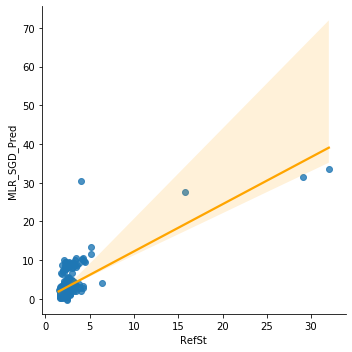

In [49]:
#With stochastic Gradient Descent
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
# Model
# sgdr = SGDRegressor(loss='squared_loss', alpha=.001, tol=1e-5)
sgdr = SGDRegressor(loss = 'squared_error', max_iter = 5000)

# Normalize
sc = StandardScaler()
X_MLR_SGDtrain = sc.fit_transform(X_MLRtrain)
X_MLR_SGDtest = sc.transform(X_MLRtest)

# Fit
sgdr.fit(X_MLR_SGDtrain, Y_MLRtrain)

# Get MLR coefficients
print('Intercept: \n', sgdr.intercept_)
print('Coefficients: \n', sgdr.coef_)
print('Iters: \n', sgdr.n_iter_)
print(sgdr.get_params())


# Predict
df_MLRtest["MLR_SGD_Pred"] = sgdr.intercept_ + sgdr.coef_[0]*df_MLRtest["Sensor_O1"] + sgdr.coef_[1]*df_MLRtest["Temp"]+sgdr.coef_[2]*df_MLRtest["RelHum"]
# df_MLRtest["MLR_SGD_Pred"] = sgdr.predict(X_MLR_SGDtest)

# Plot linear
df_MLRtest[["RefSt", "MLR_SGD_Pred"]].plot()


# Plot regression
sns.lmplot(x = 'RefSt', y = 'MLR_SGD_Pred', data = df_MLRtest, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_MLRtest["RefSt"], y_pred = df_MLRtest["MLR_SGD_Pred"])

In [50]:
df_MLR_SGD = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"], 'Temp': canary_df["canary_temp"], 'RelHum': canary_df["canary_rh"]})
df_MLR_SGD["MLR_SGD_Pred"] = sgdr.intercept_ + sgdr.coef_[0]*df_MLR_SGD["Sensor_O1"] + sgdr.coef_[1]*df_MLR_SGD["Temp"] + sgdr.coef_[2]*df_MLR_SGD["RelHum"]
df_MLR_SGD = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_SGD': df_MLR_SGD["MLR_SGD_Pred"]})
Sensor_plot_SGD = df_MLR_SGD[["Sensor_SGD", "RefSt"]]
Sensor_plot_SGD.plot()
